# Regression model

First, let's try a regression model. We can use a week of stats for a given player as input, and try to predict the next week's stats as the output.

In [1]:
# Standard library imports
import pickle
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# Input data
data_file='../data/parsed_data_all_positions.pkl'

## 1. Data loading

In [2]:
position_data=pickle.load(open(data_file, 'rb'))
print(f'Positions: {position_data.keys()}')

Positions: dict_keys(['qb', 'rb', 'wr', 'te'])


In [3]:
position_data['qb'].head()

Rank   Age   Exp  G Cmp Att   Cm%  PYd  Y/Att PTD  \
Season Week Player                                                             
2020   1    Josh Allen        1  24.0   3.0  1  33  46  71.7  312   6.78   2   
            Russell Wilson    2  32.0   9.0  1  31  35  88.6  322   9.20   4   
            Aaron Rodgers     3  37.0  16.0  1  32  44  72.7  364   8.27   4   
            Lamar Jackson     4  23.0   3.0  1  20  25  80.0  275  11.00   3   
            Kyler Murray      5  23.0   2.0  1  26  40  65.0  230   5.75   1   

                           Int Rsh RshYd RshTD  FP/G FantPt Scoring profile  \
Season Week Player                                                            
2020   1    Josh Allen       0  14    57     1  32.2   32.2               p   
            Russell Wilson   0   3    29     0  31.8   31.8               p   
            Aaron Rodgers    0   1     2     0  30.8   30.8               p   
            Lamar Jackson    0   7    45     0  27.5   27.5               p   
            Kyler Murray     1  13    91     1  26.3   26.3               p   

                           Team  
Season Week Player               
2020   1    Josh Allen      BUF  
            Russell Wilson  SEA  
            Aaron Rodgers    GB  
            Lamar Jackson   BAL  
            Kyler Murray    ARI

In [4]:
for df in position_data.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2664 entries, (np.int64(2020), np.int64(1), 'Josh Allen') to (np.int64(2023), np.int64(18), 'Logan Woodside')
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rank             2664 non-null   object
 1   Age              2664 non-null   object
 2   Exp              2664 non-null   object
 3   G                2664 non-null   object
 4   Cmp              2664 non-null   object
 5   Att              2664 non-null   object
 6   Cm%              2664 non-null   object
 7   PYd              2664 non-null   object
 8   Y/Att            2664 non-null   object
 9   PTD              2664 non-null   object
 10  Int              2664 non-null   object
 11  Rsh              2664 non-null   object
 12  RshYd            2664 non-null   object
 13  RshTD            2664 non-null   object
 14  FP/G             2664 non-null   object
 15  FantPt           2664 non-null   obje

## 2. Data formatting

### 2.1. Feature selection

In [5]:
# Drop unneeded string features
feature_drops=['Age', 'Scoring profile', 'Age', 'G', 'Team']

for position in position_data.keys():
    position_data[position].drop(feature_drops, axis=1, inplace=True)

position_data['qb'].head()

Rank   Exp Cmp Att   Cm%  PYd  Y/Att PTD Int Rsh  \
Season Week Player                                                            
2020   1    Josh Allen        1   3.0  33  46  71.7  312   6.78   2   0  14   
            Russell Wilson    2   9.0  31  35  88.6  322   9.20   4   0   3   
            Aaron Rodgers     3  16.0  32  44  72.7  364   8.27   4   0   1   
            Lamar Jackson     4   3.0  20  25  80.0  275  11.00   3   0   7   
            Kyler Murray      5   2.0  26  40  65.0  230   5.75   1   1  13   

                           RshYd RshTD  FP/G FantPt  
Season Week Player                                   
2020   1    Josh Allen        57     1  32.2   32.2  
            Russell Wilson    29     0  31.8   31.8  
            Aaron Rodgers      2     0  30.8   30.8  
            Lamar Jackson     45     0  27.5   27.5  
            Kyler Murray      91     1  26.3   26.3

### 2.2. Data clean-up

In [6]:
for position in position_data.keys():

    # Replace empty strings with NAN
    position_data[position].replace('', pd.NA, inplace=True)

    # Drop NAN containing rows
    position_data[position].dropna(inplace=True)

    # Set float dtype for all features
    position_data[position]=position_data[position].astype(float)

position_data['qb'].head()

Rank   Exp   Cmp   Att   Cm%    PYd  Y/Att  PTD  \
Season Week Player                                                            
2020   1    Josh Allen       1.0   3.0  33.0  46.0  71.7  312.0   6.78  2.0   
            Russell Wilson   2.0   9.0  31.0  35.0  88.6  322.0   9.20  4.0   
            Aaron Rodgers    3.0  16.0  32.0  44.0  72.7  364.0   8.27  4.0   
            Lamar Jackson    4.0   3.0  20.0  25.0  80.0  275.0  11.00  3.0   
            Kyler Murray     5.0   2.0  26.0  40.0  65.0  230.0   5.75  1.0   

                            Int   Rsh  RshYd  RshTD  FP/G  FantPt  
Season Week Player                                                 
2020   1    Josh Allen      0.0  14.0   57.0    1.0  32.2    32.2  
            Russell Wilson  0.0   3.0   29.0    0.0  31.8    31.8  
            Aaron Rodgers   0.0   1.0    2.0    0.0  30.8    30.8  
            Lamar Jackson   0.0   7.0   45.0    0.0  27.5    27.5  
            Kyler Murray    1.0  13.0   91.0    1.0  26.3    26.3

### 2.3. Data generator function

To test model performance we need a function format our data as pairs of features and labels regression modeling. Each feature/label pair will consist of a week's stats for a given player as the input labels and then the stats for the next week as the labels. Care must be taken to not cross season or player boundaries when generating data.

In [7]:
def generate_data(data_df: pd.DataFrame) -> Tuple[np.array, np.array]:
    '''Takes dataframe, input window size, parses data into feature label pairs,
    returns as tuple of numpy arrays'''

    # Get list of seasons
    seasons=data_df.index.get_level_values('Season').unique().tolist()

    features=[]
    labels=[]

    # Loop on seasons
    for season in seasons:

        # Extract the data for this season
        season_df=data_df.loc[(season),:,:]
        
        # Get the list of player for this season
        players=season_df.index.get_level_values('Player').unique().tolist()

        # loop on the players
        for player in players:

            # Extract the data for this player
            player_df=season_df.loc[:,(player),:]

            # Indexing variable for batch
            input_start_index=0

            # Loop on the player data
            while input_start_index + 1 < len(player_df):

                # Extract and collect the features and labels
                features.append(player_df.iloc[input_start_index].values.tolist())
                label_row=player_df.iloc[input_start_index + 1]
                labels.append(label_row['FantPt'])

                # Update the index
                input_start_index+=1

    return np.array(features), np.array(labels)

## 3. Training/testing data preparation

The data needs to be standardized along columns for regression. Take care to fit the scaler on the training data only, then use it to transform the training and testing data.

In [8]:
position_training_features={}
position_training_labels={}
position_testing_features={}
position_testing_labels={}
position_feature_scalers={}
position_label_scalers={}

for position in position_data.keys():
    
    # Generate feature-label pairs for each position
    features, labels=generate_data(position_data[position])

    # Split them into training and validation
    training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)

    # Scale the data
    feature_scaler=StandardScaler()
    feature_scaler.fit(training_features)
    position_training_features[position]=feature_scaler.transform(training_features)
    position_testing_features[position]=feature_scaler.transform(testing_features)

    label_scaler=StandardScaler()
    label_scaler.fit(training_labels.reshape(-1, 1))
    position_training_labels[position]=label_scaler.transform(training_labels.reshape(-1, 1))
    position_testing_labels[position]=label_scaler.transform(testing_labels.reshape(-1, 1))

    # Save the scalers for later
    position_feature_scalers[position]=feature_scaler
    position_label_scalers[position]=label_scaler

    print(f'\nPosition: {position}')
    print(f'Training features: {training_features.shape}')
    print(f'Training labels: {training_labels.shape}')
    print(f'Testing features: {testing_features.shape}')
    print(f'Testing labels: {testing_labels.shape}')


Position: qb
Training features: (1614, 14)
Training labels: (1614,)
Testing features: (538, 14)
Testing labels: (538,)

Position: rb
Training features: (3503, 11)
Training labels: (3503,)
Testing features: (1168, 11)
Testing labels: (1168,)

Position: wr
Training features: (5103, 11)
Training labels: (5103,)
Testing features: (1701, 11)
Testing labels: (1701,)

Position: te
Training features: (2496, 8)
Training labels: (2496,)
Testing features: (832, 8)
Testing labels: (832,)


## 4. Multiple linear regression model

In [11]:
# Loop and fit a model for each position
position_models={}
position_predictions={}

for position in position_data.keys():

    # Fit the model on the training data and make predictions for the testing data
    position_models[position]=LinearRegression().fit(position_training_features[position], position_training_labels[position])
    position_predictions[position]=position_models[position].predict(position_testing_features[position])

    # Un-scale the predictions and labels
    position_testing_labels[position]=position_label_scalers[position].inverse_transform(position_testing_labels[position])
    position_predictions[position]=position_label_scalers[position].inverse_transform(position_predictions[position])

    # Calculate RMSE
    rmse=root_mean_squared_error(position_predictions[position], position_testing_labels[position])
    print(f'{position} FanPt RMSE: {rmse}')


qb FanPt RMSE: 7.901643536662082
rb FanPt RMSE: 7.3814472318695366
wr FanPt RMSE: 7.477409710316285
te FanPt RMSE: 5.817336194869116


## 5. Plot predictions

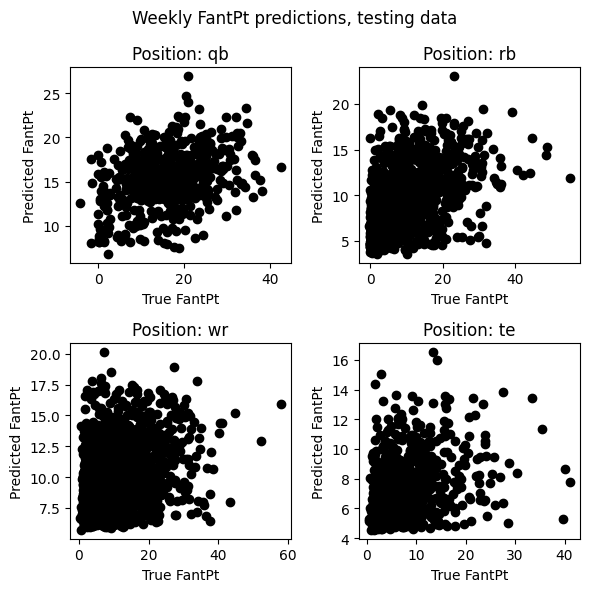

In [12]:
# Set-up a 2x2 figure 
fig, axs=plt.subplots(2,2, figsize=(6,6))
axs=axs.flatten()

# Add the main title
fig.suptitle('Weekly FantPt predictions, testing data', size='large')

for ax, position in zip(axs, position_data.keys()):
    ax.set_title(f'Position: {position}')
    ax.scatter(position_testing_labels[position], position_predictions[position], color='black')
    ax.set_xlabel('True FantPt')
    ax.set_ylabel('Predicted FantPt')

plt.tight_layout()
plt.show()